In [1]:
from collections import defaultdict
from itertools import permutations
import math
import os

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
Number of GPU Available: 4
GPU: Tesla V100-SXM2-32GB


In [3]:
df = pd.read_pickle("../data/fd_vn_physical_with_tokens_and_pooled_output.pkl")

In [4]:
df.head()

,cc,sentence,syntax,fd,tokens,tokens_pt,tokens_ids,token_wise_output,pooled_output
0,"[{'text': 'cart', 'q_value': '+MER', 'index': ...",The grocery cart hit against the wall,Sbj V PathP,Autonomous Place,"[the, grocery, cart, hit, against, the, wall]","[[tensor(101), tensor(1996), tensor(13025), te...","[1996, 13025, 11122, 2718, 2114, 1996, 2813]","[[[tensor(-0.2603), tensor(0.5590), tensor(-0....","[[tensor(-0.8683), tensor(-0.2977), tensor(-0...."
1,"[{'text': 'type', 'q_value': '+MER', 'index': ...",That type of rope coiled easily around the post,Sbj V PathP,Autonomous Place,"[that, type, of, rope, coiled, easily, around,...","[[tensor(101), tensor(2008), tensor(2828), ten...","[2008, 2828, 1997, 8164, 24599, 4089, 2105, 19...","[[[tensor(-0.1397), tensor(-0.2141), tensor(0....","[[tensor(-0.7615), tensor(-0.0670), tensor(0.1..."
2,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",The rope coiled around the post,Sbj V PathP,Autonomous Place,"[the, rope, coiled, around, the, post]","[[tensor(101), tensor(1996), tensor(8164), ten...","[1996, 8164, 24599, 2105, 1996, 2695]","[[[tensor(-0.0777), tensor(0.0408), tensor(0.1...","[[tensor(-0.6512), tensor(-0.0065), tensor(0.7..."
3,"[{'text': 'company', 'q_value': '+MER', 'index...",The company is wedging into new markets,Sbj V PathP,Autonomous Place,"[the, company, is, wed, ##ging, into, new, mar...","[[tensor(101), tensor(1996), tensor(2194), ten...","[1996, 2194, 2003, 21981, 4726, 2046, 2047, 6089]","[[[tensor(0.0615), tensor(0.1368), tensor(0.30...","[[tensor(-0.8246), tensor(-0.1659), tensor(0.2..."
4,"[{'text': 'computer', 'q_value': '+MER', 'inde...",The computer connected well to the network,Sbj V PathP,Autonomous Place,"[the, computer, connected, well, to, the, netw...","[[tensor(101), tensor(1996), tensor(3274), ten...","[1996, 3274, 4198, 2092, 2000, 1996, 2897]","[[[tensor(-0.0860), tensor(-0.0513), tensor(0....","[[tensor(-0.6017), tensor(-0.1227), tensor(0.6..."


In [5]:
df.iloc[0].cc

[{'text': 'cart',
  'q_value': '+MER',
  'index': 3,
  'fd_subsequent': 7,
  'fd_relation': 'PTH'},
 {'text': 'wall', 'q_value': 'EXIST', 'index': 7, 'fd_relation': 'None'}]

In [6]:
def get_all_unique_fd_relations(df):
    all_fd_relations = []
    all_ccs = df.cc
    for cc in all_ccs:
        for token_bundle in cc:
            fd_relation = token_bundle["fd_relation"]
            if fd_relation not in all_fd_relations:
                all_fd_relations.append(fd_relation)
                
    return sorted(all_fd_relations)
    
    
all_fd_relations = get_all_unique_fd_relations(df)
all_fd_relations

['AFF',
 'CAUSE',
 'CTR',
 'FORM',
 'FRC',
 'INT',
 'MNP',
 'None',
 'PTH',
 'PTH-comp',
 'XPR']

In [7]:
def make_idx_to_token_bundle_dict(cc_arr):
    token_bundle_dct = {}
    for t in cc_arr:
        
        if "fd_subsequent" in t:
            fd_sub = t["fd_subsequent"]
        else:
            fd_sub = -1

        token_bundle_dct[t["index"]] =  token_dct = {"text": t["text"], 
                                            "fd_subsequent": fd_sub,
                                            "fd_relation": t["fd_relation"]}
    return token_bundle_dct


def get_all_key_permutations(keys):
    return list(permutations(keys,2))


def get_sentence_with_two_entities_and_relation(df):
    all_sentences_with_entities_and_relations_bundles = []
    all_ccs = df.cc
    all_sentences = df.sentence
    
    for cc, sent in zip(all_ccs, all_sentences):
        
        token_bundle_dct = make_idx_to_token_bundle_dict(cc)
        #print(token_bundle_dct)
        
        keys = token_bundle_dct.keys()
        
        all_key_permutations = get_all_key_permutations(keys)
        #print(all_key_permutations)
        # e.g., [(3, 7), (7, 3)]
        
        for key_perm in all_key_permutations:
            
            token0 = token_bundle_dct[key_perm[0]]["text"]
            token1 = token_bundle_dct[key_perm[1]]["text"]
            
            if token_bundle_dct[key_perm[0]]["fd_subsequent"] == key_perm[1]:
                fd_relation = all_fd_relations.index(token_bundle_dct[key_perm[0]]["fd_relation"])
            else:
                fd_relation = all_fd_relations.index("None")
            
            feature_arr = [sent, token0, token1, fd_relation]
            
            all_sentences_with_entities_and_relations_bundles.append(feature_arr)
            
    return all_sentences_with_entities_and_relations_bundles
            
     
all_sentences_with_entities_and_relations_bundles = get_sentence_with_two_entities_and_relation(df) 

all_sentences_with_entities_and_relations_bundles[80:90]

[['He wedged the diamond between shifting dunes', 'dunes', 'He', 7],
 ['He wedged the diamond between shifting dunes', 'dunes', 'diamond', 7],
 ['Paula hit the stick against the fence', 'Paula', 'stick', 4],
 ['Paula hit the stick against the fence', 'Paula', 'fence', 7],
 ['Paula hit the stick against the fence', 'stick', 'Paula', 7],
 ['Paula hit the stick against the fence', 'stick', 'fence', 8],
 ['Paula hit the stick against the fence', 'fence', 'Paula', 7],
 ['Paula hit the stick against the fence', 'fence', 'stick', 7],
 ['Smith inscribed his name on the ring', 'Smith', 'name', 4],
 ['Smith inscribed his name on the ring', 'Smith', 'ring', 7]]

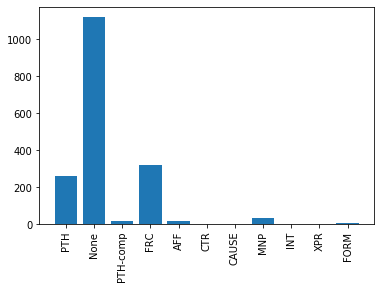

In [8]:
cnt_fd_relations = defaultdict(int)

for bundle in all_sentences_with_entities_and_relations_bundles:
    cnt_fd_relations[all_fd_relations[bundle[3]]] += 1
    
plt.bar(range(len(cnt_fd_relations)), list(cnt_fd_relations.values()), align='center')
plt.xticks(range(len(cnt_fd_relations)), list(cnt_fd_relations.keys()), rotation=90)
plt.show()

In [9]:
sentences = [(f[0] + " [SEP] " + f[1] + " " + f[2] + " [SEP] [CLS]") for f in all_sentences_with_entities_and_relations_bundles]
sentences[0:10]

labels = [f[3] for f in all_sentences_with_entities_and_relations_bundles]
labels[0:10]

[8, 7, 8, 7, 8, 7, 8, 7, 8, 7]

In [10]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts[0]

['▁the',
 '▁grocery',
 '▁cart',
 '▁hit',
 '▁against',
 '▁the',
 '▁wall',
 '▁[',
 's',
 'ep',
 ']',
 '▁cart',
 '▁wall',
 '▁[',
 's',
 'ep',
 ']',
 '▁[',
 'cl',
 's',
 ']']

In [11]:
MAX_LEN = 20

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [12]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [13]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [14]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=16, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=16, test_size=0.25)

In [15]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [17]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", 
                                                       num_labels=len(all_fd_relations),
                                                      dropout=0.1)
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [18]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [19]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 12

# Tracking predictions and labels for confusion matrix
y_pred = []
y_true = []

# trange is a tqdm wrapper around the normal python range
for epoch in trange(epochs, desc="Epoch"):
    
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    
    if epoch == epochs-1:
        y_pred.extend(np.argmax(logits, axis=1).flatten())
        y_true.extend(label_ids.flatten())

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 1.3120845414343334


Epoch:   8%|▊         | 1/12 [00:03<00:37,  3.43s/it]

Validation Accuracy: 0.6236607142857142
Train loss: 1.093985222634815


Epoch:  17%|█▋        | 2/12 [00:06<00:33,  3.36s/it]

Validation Accuracy: 0.6236607142857142
Train loss: 1.0171613281681424


Epoch:  25%|██▌       | 3/12 [00:09<00:29,  3.30s/it]

Validation Accuracy: 0.6642857142857144
Train loss: 0.857729720217841


Epoch:  33%|███▎      | 4/12 [00:12<00:26,  3.26s/it]

Validation Accuracy: 0.6995535714285713
Train loss: 0.6661126869065421


Epoch:  42%|████▏     | 5/12 [00:16<00:22,  3.24s/it]

Validation Accuracy: 0.759970238095238
Train loss: 0.5241439296376138


Epoch:  50%|█████     | 6/12 [00:19<00:19,  3.22s/it]

Validation Accuracy: 0.7421130952380952
Train loss: 0.3970203342891875


Epoch:  58%|█████▊    | 7/12 [00:22<00:16,  3.20s/it]

Validation Accuracy: 0.8092261904761905
Train loss: 0.31284282888684956


Epoch:  67%|██████▋   | 8/12 [00:25<00:12,  3.19s/it]

Validation Accuracy: 0.7913690476190477
Train loss: 0.2307999378868512


Epoch:  75%|███████▌  | 9/12 [00:28<00:09,  3.19s/it]

Validation Accuracy: 0.8227678571428572
Train loss: 0.19444703434904417


Epoch:  83%|████████▎ | 10/12 [00:31<00:06,  3.19s/it]

Validation Accuracy: 0.8117559523809524
Train loss: 0.18821267357894353


Epoch:  92%|█████████▏| 11/12 [00:35<00:03,  3.18s/it]

Validation Accuracy: 0.8427083333333334
Train loss: 0.14796887072069304


Epoch: 100%|██████████| 12/12 [00:38<00:00,  3.19s/it]

Validation Accuracy: 0.8409226190476191


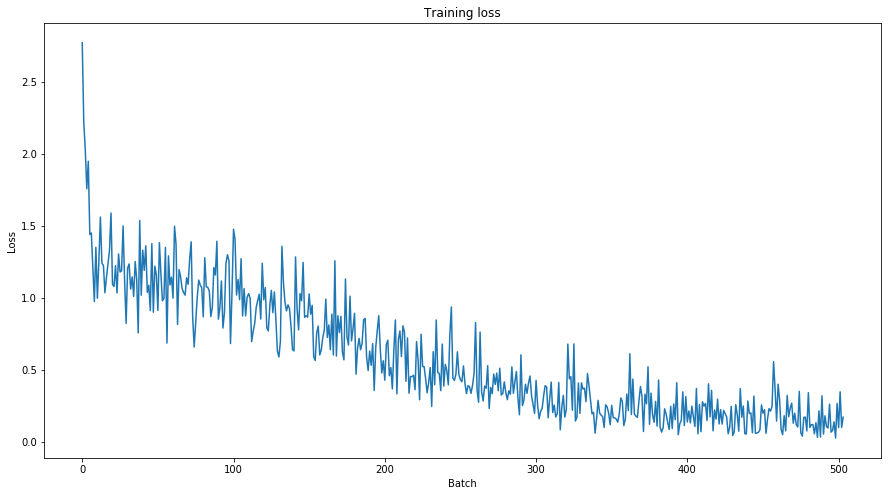

In [22]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [23]:
set(y_pred)

{0, 3, 4, 6, 7, 8, 9}

In [24]:
len(y_pred)

446

In [25]:
set(y_true)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [26]:
all_fd_relations_for_valid = [all_fd_relations[idx] for idx in set(y_true)]
all_fd_relations_for_valid

['AFF', 'CAUSE', 'CTR', 'FORM', 'FRC', 'INT', 'MNP', 'None', 'PTH', 'PTH-comp']

In [27]:
c_matrix = confusion_matrix(y_true, y_pred)
c_matrix

array([[  2,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   3,   0,   0],
       [  0,   0,   0,   0,  66,   0,   1,  10,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   3,   0,   4,   0,   0,   0],
       [  1,   0,   0,   1,  12,   0,   2, 256,   4,   2],
       [  0,   0,   0,   0,   6,   0,   0,  17,  45,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   2]])

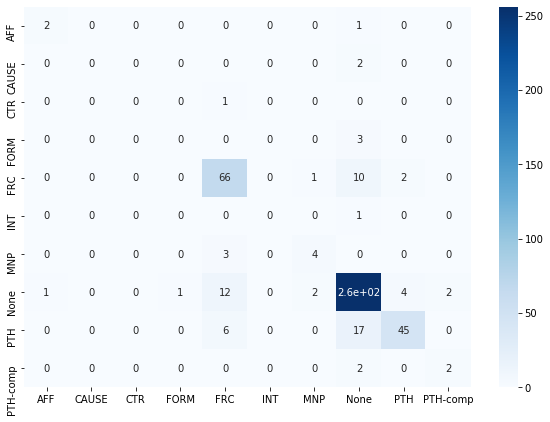

In [28]:
def plot_confusion_matrix(c_matrix):
    df_cm = pd.DataFrame(c_matrix, index = [i for i in all_fd_relations_for_valid],
                  columns = [i for i in all_fd_relations_for_valid])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    
plot_confusion_matrix(c_matrix)

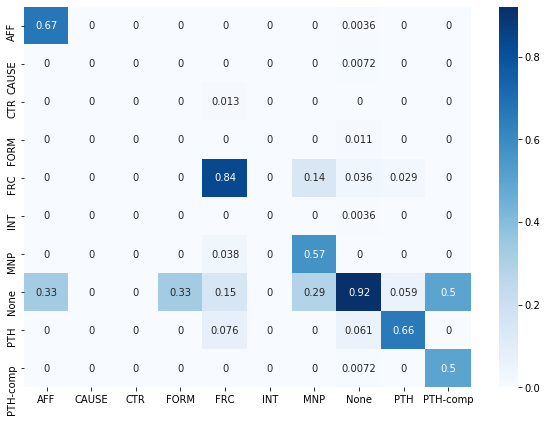

In [29]:
recall_matrix = c_matrix / c_matrix.astype(np.float).sum(axis=1)
plot_confusion_matrix(recall_matrix)

/nfs/student/r/regan/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


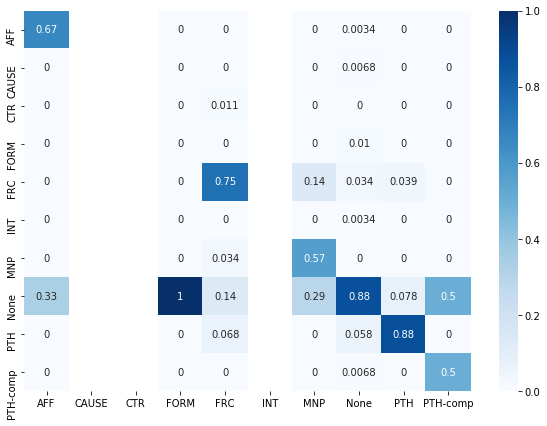

In [30]:
precision_matrix = c_matrix / c_matrix.astype(np.float).sum(axis=0)
plot_confusion_matrix(precision_matrix)

In [31]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 24

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

FileNotFoundError: [Errno 2] File out_of_domain_dev.tsv does not exist: 'out_of_domain_dev.tsv'

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)